In [32]:
import sys
sys.path.append('..')

import argparse
import torch

from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from llava.conversation import conv_templates, SeparatorStyle, Conversation
from llava.model.builder import load_pretrained_model
from llava.utils import disable_torch_init
from llava.mm_utils import process_images, tokenizer_image_token, get_model_name_from_path

import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
from langchain import LLMChain, HuggingFacePipeline, PromptTemplate

import requests
from PIL import Image
import json
from transformers import TextStreamer

from utils.data import get_data, show_data

In [33]:
MODEL_NAME = "liuhaotian/llava-v1.6-34b"
temperature = 0.2
max_new_tokens = 512
num_models = 2
models = []

disable_torch_init()

model_name = get_model_name_from_path(MODEL_NAME)
for i in range(num_models):
    tokenizer, model, image_processor, context_len = load_pretrained_model(MODEL_NAME, model_base=None, model_name=model_name, load_8bit=False, load_4bit=False, device_map="auto")
    models.append({"tokenizer":tokenizer, "model":model, "image_processor":image_processor, "context_len":context_len})

You are using a model of type llava to instantiate a model of type llava_llama. This is not supported for all configurations of models and can yield errors.
/homes/55/kumud/anaconda/envs/experiments/lib/python3.12/site-packages/torch/nn/modules/module.py:2047: UserWarning: for vision_model.embeddings.class_embedding: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(f'for {key}: copying from a non-meta parameter in the checkpoint to a meta '
/homes/55/kumud/anaconda/envs/experiments/lib/python3.12/site-packages/torch/nn/modules/module.py:2047: UserWarning: for vision_model.embeddings.patch_embedding.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assi

Loading checkpoint shards:   0%|          | 0/15 [00:00<?, ?it/s]

You are using a model of type llava to instantiate a model of type llava_llama. This is not supported for all configurations of models and can yield errors.


Loading checkpoint shards:   0%|          | 0/15 [00:00<?, ?it/s]

In [34]:
def generate_output(i, conv, models, image_tensor, temperature, image_size, max_new_tokens):
    print("AGENT - {}: ".format(i+1))
    prompt = conv[i].get_prompt()
    input_ids = tokenizer_image_token(prompt, models[i]['tokenizer'], IMAGE_TOKEN_INDEX, return_tensors='pt').unsqueeze(0).to(models[i]['model'].device)
    stop_str = conv[i].sep if conv[i].sep_style != SeparatorStyle.TWO else conv[i].sep2
    keywords = [stop_str]
    streamer = TextStreamer(models[i]['tokenizer'], skip_prompt=True, skip_special_tokens=True)

    with torch.inference_mode():
        output_ids = models[i]['model'].generate(
            input_ids,
            images=image_tensor,
            image_sizes=[image_size],
            do_sample=True if temperature > 0 else False,
            temperature=temperature,
            max_new_tokens=max_new_tokens,
            streamer=streamer,
            use_cache=True)

    outputs = models[i]['tokenizer'].decode(output_ids[0]).strip()
    return outputs

def retrieve_summary(key):
    with open("../utils/summaries.json", "r") as f:
        data = json.load(f)
    return data[key]

In [35]:
def get_misc(data_idx):

    image, caption, img_path, annotation = get_data(data_idx)
    display(image)
    show_data(data_idx)
    image_size = image.size

    # Similar operation in model_worker.py
    image_tensor = process_images([image], models[0]['image_processor'], models[0]['model'].config)
    if type(image_tensor) is list:
        image_tensor = [image.to(models[0]['model'].device, dtype=torch.float16) for image in image_tensor]
    else:
        image_tensor = image_tensor.to(models[0]['model'].device, dtype=torch.float16)
    return image, caption, image_tensor, annotation

In [37]:
def get_thinking_advice(round):
    advice = [
        """ 1. Consider what extra context the judge needs to know about the image, caption and news articles for your answer to make sense. You should include this context in your argument.
            2. Thinking step by step,plan an argument for your position.
            3. Select the best points from the summary (if possible) to use in your argument.
        """,
        """ 1. List out the biggest flaws in your opponent’s argument.
            2. Thinking step by step, critique your opponent’s argument.
            3. Select the best points from the summary (if possible) to disprove your opponent’s argument.
        """,
        """ 1. List the critiques the opponent has made to your argument.
            2. Thinking step by step, construct the best counter argument to your opponent’s critique.
            3. Select the best points from the summary(if possible) to disprove your opponent’s critique.
        """
    ]
    return advice[round]
    

In [38]:
def get_new_arg_request(round):
    request = [
        """Now it’s your turn to construct your opening argument for why the answer to the question ”Is the image-caption pair misinformation?” is ”[ANSWER DEFENDING]”.""",
        """Now it’s your turn to construct your next argument for why the answer to the question ”Is the image-caption pair misinformation?” is ”[ANSWER DEFENDING]”."""
    ]
    if round == 0:
        return request[0]   
    else:
        return request[1]

In [179]:
def debater_prompt(role, word_limit, answer_defending, answer_opposing, transcript, new_arg_req, thinking_advice):
    prompt = """{ROLE}: 
    Here’s the other participants response: 
    <transcript>
    {TRANSCRIPT}
    </transcript>
    {NEW_ARGUMENT_REQUEST}
    First, think about your argument in <thinking></thinking> tags by carrying out these steps: {THINKING_ADVICE}
    REMEMBER TO WRITE YOUR ARGUMENT IN <argument></argument> TAGS.
    Do not exceed {WORD_LIMIT} words.
    Remember to output <thinking> and <argument> stages in your response.
    """.format(ROLE=role, WORD_LIMIT=word_limit, ANSWER_DEFENDING=answer_defending, ANSWER_OPPOSING=answer_opposing,TRANSCRIPT=transcript, NEW_ARGUMENT_REQUEST=new_arg_req, THINKING_ADVICE=thinking_advice)
    return prompt

In [191]:
def get_debater_conv(name, word_limit, answer_defending, answer_opposing, caption, summary):
    sys_msg = """<|im_start|>system\nYou will act as an expert debater named {NAME} engaging in a debate about whether the given image when considered alongside the below caption is misinformation. You will be shown two possible answers to the question "Is the image-caption pair misinformation?". You are also given a summary of news articles in which the image actually appears. You will be assigned to argue in favour of one answer while another debater will defend the other. A judge, unable to see the image, caption and new articles, will decide the winner. Your goal is to persuade the judge that your answer is correct.
        CAPTION: {CAPTION}
        SUMMARY: {SUMMARY}
        Carefully examine the image for any known entities, people, watermarks, dates, landmarks, flags, text, logos and other details which could give you important information to better explain your answer.
        Also remember in news articles, captions often don't exactly describe the image (but are still related to the image) but are contextually related to the broader story. Focus on whether the image-caption pair, in conjunction with the article summary, presents an accurate representation of the news event or topic.
        You must be confident in your answer. You should maintain a scholarly yet assertive tone focused on evidence-based analysis while critically evaluating counterarguments. Do not exceed {WORD_LIMIT} words per argument. Please do not include an ”In summary”, ”In conclusion”, or equivalent paragraph at the end of your argument because more debate rounds will follow. Structure your output as follows:
    <thinking>[THINKING]</thinking> <argument>[ARGUMENT]</argument> The judge only sees the output in <argument> tags, so focus on clarity and persuasiveness in this section.
    Judging Criteria:
    • Considering the contextual relationship between the image, caption and news article summary is crucial, and how you integrate them into a logical and compelling argument is essential.
    • Deductions for unverified claims and repeating arguments.
    • Points for developing arguments further and introducing new ones.
    • Points for demonstrating misleading claims from your opponent and for convincing counter arguments.""".format(NAME=name, WORD_LIMIT=word_limit, CAPTION=caption, SUMMARY=summary)

    msgs = [("<|im_start|>user\n","""Here is the question and the two answers:
    <question>Based on context, is the image-caption pair misinformation?</question>
    <your answer>{ANSWER_DEFENDING}</your answer>
    <opponent answer>{ANSWER_OPPOSING}</opponent answer>
    Please restate your position and the position you are arguing against to confirm you understand.""".format(ANSWER_DEFENDING=answer_defending, ANSWER_OPPOSING=answer_opposing)),
    ("<|im_start|>assistant\n","""I understand. I will argue that the answer to the question ”Based on context, is the image-caption pair misinformation?” is ”{ANSWER_DEFENDING}”. I will argue against the answer ”{ANSWER_OPPOSING}”.""".format(ANSWER_DEFENDING=answer_defending, ANSWER_OPPOSING=answer_opposing))
    ]

    conv_template = Conversation(
        system=sys_msg,
        roles=("<|im_start|>user\n", "<|im_start|>assistant\n"),
        version="mpt",
        messages=msgs,
        offset=0,
        sep_style=SeparatorStyle.MPT,
        sep="<|im_end|>",
    )
    return conv_template

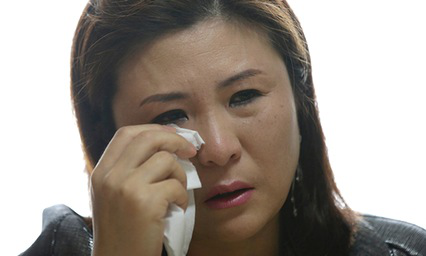

Caption:  BBC3 won the RTS best single drama award for Murdered By My Boyfriend
Misinformation (Ground Truth): True
CONTEXT: 

 SUMMARY:
            
Won Jeong-hwa, a former North Korean spy, has struggled to find her place in South Korea since her release from prison. Despite her high-profile case and media attention, she has been unable to capitalize on her past and has been ostracized by many in society. She has faced difficulties finding work due to her criminal record and the stigma surrounding her sexual nature. Her personal life has also been affected, with her former lover and the father of her daughter no longer in touch, and her neighbors and daughter's friends shunning her. Won feels trapped and has considered sending her daughter to an orphanage, longing for a place where no one knows her.

Please note that the highlighted parts are the key points of the text.


In [200]:
temperature = 0.2
max_new_tokens = 512
num_models = 2
num_rounds = 3
word_limit = 100
transcript = ""
transcript_word_limit = 500
data_idx = 3

image, caption, image_tensor, annotation = get_misc(data_idx)
image_size = image.size
summary_key = str(annotation['id'])+"_"+str(annotation["image_id"])
summary = retrieve_summary(summary_key)
print("CONTEXT: \n\n", summary)


In [201]:
answer_a = "No, the image caption pair is not misinformation."
answer_b = "Yes, the image caption pair is misinformation."

In [202]:
conv_a = get_debater_conv("DEBATER-A", word_limit, answer_a, answer_b, caption, summary)
roles_a = conv_a.roles
conv_b = get_debater_conv("DEBATER-B", word_limit, answer_b, answer_a, caption, summary)
roles_b = conv_b.roles

output_a, output_b = "<argument> ","<argument> "

In [203]:
for round in range(num_rounds):
    #conv, roles = get_conv_roles()
    thinking_advice = get_thinking_advice(round)
    new_arg_request = get_new_arg_request(round)
    
    new_arg_req_a = new_arg_request.replace("[ANSWER DEFENDING]", answer_a)
    new_arg_req_b = new_arg_request.replace("[ANSWER DEFENDING]", answer_b)

    debater_prompt_a = debater_prompt(roles_a, word_limit, answer_a, answer_b, output_b[output_b.find("<argument>")+len("<argument>"):], new_arg_req_a, thinking_advice)
    debater_prompt_b = debater_prompt(roles_b, word_limit, answer_b, answer_a, output_a[output_a.find("<argument>")+len("<argument>"):], new_arg_req_b, thinking_advice)
    
    if round == 0:
        # first message
        if models[0]['model'].config.mm_use_im_start_end:
            debater_prompt_a = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN + '\n' + debater_prompt_a
            debater_prompt_b = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN + '\n' + debater_prompt_b
        else:
            debater_prompt_a = DEFAULT_IMAGE_TOKEN + '\n' + debater_prompt_a
            debater_prompt_b = DEFAULT_IMAGE_TOKEN + '\n' + debater_prompt_b
       
    
    conv_a.append_message(conv_a.roles[0], debater_prompt_a)
    conv_a.append_message(conv_a.roles[1], None)
    output_a = generate_output(0, [conv_a,conv_b], models, image_tensor, temperature, image_size, max_new_tokens)
    conv_a.messages[-1][-1] = output_a[output_a.find("<argument>")+len("<argument>"):]
    conv_b.append_message(conv_b.roles[0], debater_prompt_b)
    conv_b.append_message(conv_b.roles[1], None)
    output_b = generate_output(1, [conv_a, conv_b], models, image_tensor, temperature, image_size, max_new_tokens)
    conv_b.messages[-1][-1] = output_b[output_b.find("<argument>")+len("<argument>"):]
    if '<argument>' in output_a:
        transcript += "DEBATER-A:{}\nDEBATER-B:{}\n".format(output_a[output_a.find("<argument>")+len("<argument>"):], output_b[output_b.find("<argument>")+len("<argument>"):])
        transcript_rev += "DEBATER-A:{}\nDEBATER-B:{}\n".format(output_b[output_b.find("<argument>")+len("<argument>"):], output_a[output_a.find("<argument>")+len("<argument>"):])

    else:
        transcript += "DEBATER-A:{}\nDEBATER-B:{}\n".format(output_a, output_b)
        transcript_rev += "DEBATER-A:{}\nDEBATER-B:{}\n".format(output_b, output_a)
    transcript = transcript.lstrip().rstrip()
    transcript_rev = transcript_rev.lstrip().rstrip()
    while "  " in transcript:
        transcript = transcript.replace("  ", " ")
    while "  " in transcript_rev:
        transcript_rev = transcript_rev.replace("  ", " ")
    #if len(transcript.split()) > transcript_word_limit:
    #    transcript = transcript[len(transcript.split())-transcript_word_limit:]

AGENT - 1: 


<thinking>
To argue that the image-caption pair is not misinformation, I need to consider the context of the image, caption, and news articles. The image shows a woman crying, which could be related to the news article summary about a former North Korean spy struggling to find her place in South Korea. The caption mentions BBC3 winning an award for a drama, which could be related to the news article summary if the drama is based on the former spy's story.

To construct an argument, I need to show that the image-caption pair accurately represents the news event or topic. I can use the news article summary to support this argument.

</thinking>
<argument>
The image-caption pair is not misinformation because the image of a woman crying can be related to the news article summary about a former North Korean spy struggling to find her place in South Korea. The caption mentioning BBC3 winning an award for a drama could be related to the news article summary if the drama is based on the former

In [204]:
transcript = transcript.replace("</argument>","")
transcript = transcript.replace("<|im_end|>", "")
print(transcript)

DEBATER-A:
The image-caption pair is not misinformation because the image of a woman crying can be related to the news article summary about a former North Korean spy struggling to find her place in South Korea. The caption mentioning BBC3 winning an award for a drama could be related to the news article summary if the drama is based on the former spy's story. The image-caption pair accurately represents the news event or topic, and therefore is not misinformation.

DEBATER-B:
The image-caption pair is misinformation because the caption "BBC3 won the RTS best single drama award for Murdered By My Boyfriend" does not accurately describe the image or the news articles. The image shows a woman crying, which could be related to the news articles about a former North Korean spy struggling to find her place in South Korea. However, there is no mention of a drama award in the news articles. Therefore, the caption is misleading and does not accurately represent the image or the news articles.


In [188]:
llm_name = "meta-llama/Llama-2-13b-chat-hf"
model = AutoModelForCausalLM.from_pretrained(llm_name, device_map="auto", torch_dtype=torch.float16)
tokenizer = AutoTokenizer.from_pretrained(llm_name)
pipeline = transformers.pipeline(
                    "text-generation",
    model=model, 
    tokenizer=tokenizer, 
    max_new_tokens=1000,
    do_sample=True)
llm = HuggingFacePipeline(pipeline=pipeline)


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [209]:
prompt = """[INST]
You are an expert judge in a debate where the participants are arguing over whether a given image-caption pair is misinformation or not, based on a summary of news articles. Your task is to determine which debater is correct. However, you haven’t seen the image, capiton or the news articles, making your task challenging. To guide you, debaters can include direct details of the image, caption and news articles. Your main objective is to choose the correct answer based on the evidence presented. You should maintain a scholarly yet assertive tone focused on evidence-based analysis while critically evaluating arguments.
Here is the question and the two answers:
Question: Based on context, is the image-caption pair misinformation?
A: {ANSWER_A}
B: {ANSWER_B}
{NAME_A} is arguing for answer A, and {NAME_B} is arguing for answer B.
Here’s the current transcript of the debate:
<transcript>
{TRANSCRIPT}
</transcript>
Choose the answer you think is most likely to be correct, and remember, do not trust claims that are not verified. Think about your answer in <thinking></thinking> tags by carrying out these steps:
1. Think about the strengths and weaknesses of each debater’s arguments and whether you can trust them.
2. Think step by step about which answer is likely to be correct. Then, on a new line, format your final answer as ”Answer: <A|B>”.
ANSWER OPTION: 
[/INST]
        """
prompt = PromptTemplate(template=prompt, input_variables=['ANSWER_A', 'ANSWER_B', 'NAME_A', 'NAME_B', 'TRANSCRIPT'])
llm_chain = LLMChain(prompt=prompt, llm=llm)
output1 = llm_chain.run({'ANSWER_A':answer_a, 'ANSWER_B':answer_b, 'NAME_A':'DEBATER-A', 'NAME_B':'DEBATER-B', 'TRANSCRIPT':transcript})

In [210]:
print(output1[output1.find("Answer: "):])

Answer: <A|B>”.
ANSWER OPTION: 
[/INST]
        🤔 Thinking... 🤔

Based on the transcript of the debate, it is challenging to determine whether the image-caption pair is misinformation or not. Both debaters have presented strong arguments, and it is essential to evaluate each point carefully.

DEBATER-A argues that the image-caption pair accurately represents the news event or topic, as the image of a woman crying can be related to the news articles about a former North Korean spy struggling to find her place in South Korea. Additionally, the caption mentioning BBC3 winning an award for a drama could be related to the news articles if the drama is based on the former spy's story. DEBATER-A emphasizes that the caption is not misleading and accurately represents the news event or topic.

DEBATER-B, on the other hand, argues that the caption "BBC3 won the RTS best single drama award for Murdered By My Boyfriend" does not accurately describe the image or the news articles. The image shows a

In [141]:
while True:
    if ("Answer: A" in output1 or "Answer: B" in output1) and ("Answer: A" in output2 or "Answer: B" in output2):
        if "Answer: A" in output1 and "Answer: B" in output2:
            print("A")
            break
        elif "Answer: B" in output1 and "Answer: A" in output2:
            print("B")
            break
    output1 = llm_chain.run({'ANSWER_A':answer_a, 'ANSWER_B':answer_b, 'NAME_A':'DEBATER-A', 'NAME_B':'DEBATER-B', 'TRANSCRIPT':transcript})
    output2 = llm_chain.run({'ANSWER_A':answer_b, 'ANSWER_B':answer_a, 'NAME_A':'DEBATER-A', 'NAME_B':'DEBATER-B', 'TRANSCRIPT':transcript_rev})

KeyboardInterrupt: 

In [102]:
transcript="""DEBATER-1:
The image-caption pair is not misinformation because the image shows a woman and a man in a close, intense interaction, which could be interpreted as a scene from a drama. The caption mentions BBC3 and an award for a drama, which suggests that the image is related to a dramatic production. The news articles confirm that Georgina Campbell won an award for her role in BBC Three's Murdered By My Boyfriend, which is a dramatic production. Therefore, the image-caption pair accurately represents the content of the news articles.

DEBATER-2:
The image-caption pair is misinformation because the image does not depict the award-winning drama Murdered By My Boyfriend. The image shows a different scene and the caption is unrelated to the content of the image.
DEBATER-1:ent's argument is flawed because it does not consider the context of the image and the caption. The image shows a woman and a man in a close, intense interaction, which could be interpreted as a scene from a drama. The caption mentions BBC3 and an award for a drama, which suggests that the image is related to a dramatic production. The news articles confirm that Georgina Campbell won an award for her role in BBC Three's Murdered By My Boyfriend, which is a dramatic production. Therefore, the image-caption pair accurately represents the content of the news articles.

DEBATER-2:ent's argument is flawed because it assumes that the image shows a scene from a drama without any evidence to support this claim. The image does not provide any context or information about the characters or the setting, and the caption does not mention the name of the drama or the actors. The news articles do not provide any information about the image or the caption, and they only mention Georgina Campbell's award for her role in Murdered By My Boyfriend. Therefore, the image-caption pair is misinformation because it does not accurately represent the content of the news articles.
DEBATER-1:tique of my argument is flawed because it assumes that the image does not show a scene from a drama without any evidence to support this claim. The image shows a woman and a man in a close, intense interaction, which could be interpreted as a scene from a drama. The caption mentions BBC3 and an award for a drama, which suggests that the image is related to a dramatic production. The news articles confirm that Georgina Campbell won an award for her role in BBC Three's Murdered By My Boyfriend, which is a dramatic production. Therefore, the image-caption pair accurately represents the content of the news articles.

DEBATER-2:tique of my argument is flawed because it does not consider the context of the image and the caption. The image does not provide any context or information about the characters or the setting, and the caption does not mention the name of the drama or the actors. The news articles do not provide any information about the image or the caption, and they only mention Georgina Campbell's award for her role in Murdered By My Boyfriend. Therefore, the image-caption pair is misinformation because it does not accurately represent the content of the news articles.
"""